In [5]:
np.savez('table.npz',energy_up_arr,energy_down_arr,magnetic_moment_up_arr,magnetic_moment_down_arr)

Save\Load table to file:

In [1]:
loaded = np.load('./cf_table_0.00.npy.npz')
energy_up_arr = loaded['arr_0']
energy_down_arr = loaded['arr_1']
magnetic_moment_up_arr = loaded['arr_2']
magnetic_moment_down_arr = loaded['arr_3']

NameError: name 'np' is not defined

# Magnetic moment and Energy calculator

Caculates the magnetic moment and energy table used in the LiHoF_4 simulation.
Includes procedures to:
* plot slices of the functions
* fit polynomials to the functions (turned out to be a dead end)

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import optimize
import math
import pandas as pd
import sys
import os
from scipy import ndimage

In [3]:
#constants
hbar=1
J=8
I=7/2
deg_J = 2 * J + 1
deg_I = 2 * I + 1
u_B=0.6717
g_L=5/4
A = 0.039 # hyperfine

In [4]:
# J matrices
jplus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m+1)) for m in np.arange(-J,J) ] ), 1)
jminus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m-1)) for m in np.arange(-J+1,J+1) ] ),-1)
jx = (jplus + jminus) * 0.5
jy = (jplus - jminus) * (-0.5j)
jz = hbar * np.diag(np.arange(-J,J+1))
I_J = np.diag(np.ones(int(round(deg_J))))

# I matrices
iplus = hbar * np.diag(np.array( [ math.sqrt(I*(I+1) - m*(m+1)) for m in np.arange(-I,I) ] ), 1)
iminus = hbar * np.diag(np.array( [ math.sqrt(I*(I+1) - m*(m-1)) for m in np.arange(-I+1,I+1) ] ),-1)
ix = (iplus + iminus) * 0.5
iy = (iplus - iminus) * (-0.5j)
iz = hbar * np.diag(np.arange(-I,I+1))
I_I = np.diag(np.ones(int(round(deg_I))))

# crystal field equivalent operators
O02 = 3 * LA.matrix_power(jz,2) - J*(J+1)*I_J
O04 = 35 * LA.matrix_power(jz,4) - 30 * J * (J+1) * LA.matrix_power(jz,2) + 25*LA.matrix_power(jz,2) - 6 * J * (J+1) * I_J + 3 * J**2 * (J+1)**2 * I_J
O44C = 0.5 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4))
O06 = 231 * LA.matrix_power(jz,6) - 315*J*(J+1)*LA.matrix_power(jz,4) + 735*LA.matrix_power(jz,4) + 105 * J**2 * (J+1)**2 * LA.matrix_power(jz,2) - 525*J*(J+1)*LA.matrix_power(jz,2) + 294*LA.matrix_power(jz,2) - 5 * J**3 * (J+1)**3 * I_J + 40 * J**2 *(J+1)**2 * I_J - 60*J*(J+1)*I_J
O46C1 = 0.25 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4)) @ (11*LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46S1 = -0.25j * (LA.matrix_power(jplus,4) - LA.matrix_power(jminus,4)) @ (11 * LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46C = O46C1 + np.transpose(np.conj(O46C1))
O46S = O46S1 + np.transpose(np.conj(O46S1))


# crystal field parameters
B02 = -0.696
B04 = 4.06e-3
B06 =  4.64e-6
B44C = 0.0418
B46C = 8.12e-4
B46S = 1.137e-4


# crystal field Hamiltonian
H_cf = B02*O02 + B04*O04 + B06*O06 + B44C*O44C + B46C*O46C + B46S*O46S

In [4]:
# linear spacing for B:
Bx = np.linspace(-2.,2.,num=80)
By = np.linspace(-2.,2.,num=80)
Bz = np.linspace(-2,2,num=80)

# alternatively, geometric spacing for B:
# (This way Bs are denser closer to 0)
"""
meanBx=0.0
maxBx=3.0       # the real max is one less than this
maxBz=3.0       # the real max is one less than this
number=40       # the real number is twice this
Bx = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1] - np.geomspace(1,maxBx,num=number)[0]
Bx = np.concatenate((np.flip(-1*Bx),Bx),axis=0)
Bx += meanBx
By = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1] - np.geomspace(1,maxBx,num=number)[0]
By = np.concatenate((np.flip(-1*By),By),axis=0)
Bz = np.geomspace(1,maxBz,num=number) - 1 + np.geomspace(1,maxBz,num=number)[1] - np.geomspace(1,maxBz,num=number)[0]
Bz = np.concatenate((np.flip(-1*Bz),Bz),axis=0)
"""
meanBx=0.0
maxBx=3.0       # the real max is one less than this
maxBz=3.0       # the real max is one less than this
number=40       # the real number is twice this
# min_bz=0.0193
# next:
#min_bz=0.00967
Bx = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1]- np.geomspace(1,maxBx,num=number)[0]
Bx = np.concatenate((np.flip(-1*Bx),Bx),axis=0)
Bx += meanBx
By = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1] - np.geomspace(1,maxBx,num=number)[0]
By = np.concatenate((np.flip(-1*By),By),axis=0)
Bz = np.geomspace(1,maxBz,num=number) - 1 + np.geomspace(1,maxBz,num=number)[1] - np.geomspace(1,maxBz,num=number)[0]
# Bz = np.geomspace(1,maxBz,num=number) - 1 + min_bz
Bz = np.concatenate((np.flip(-1*Bz),Bz),axis=0)

In [46]:
# linear spacing for B:
meanBx=0.0
Bx = meanBx + np.linspace(-2.,2.,num=81)
# Bx = np.concatenate(([Bx[0]-1.],Bx,[Bx[-1]+1.]))
By = np.linspace(-2.,2.,num=81)
# By = np.concatenate(([By[0]-1.],By,[By[-1]+1.]))

# Bz = np.linspace(-1.,1.,num=1601)
# Bz = np.concatenate(([Bz[0]-1.],Bz,[Bz[-1]+1.]))
Bz = np.array([-2.,2.])

In [ ]:
# standard
res_energy_up=[]
res_energy_down=[]
res_magnetic_moment_up=[]
res_magnetic_moment_down=[]
for i, bz in enumerate(Bz):
    res_energy_y_up=[]
    res_energy_y_down=[]
    res_magnetic_moment_y_up=[]
    res_magnetic_moment_y_down=[]
    for by in By:
        res_energy_x_up=[]
        res_energy_x_down=[]
        res_magnetic_moment_x_up=[]
        res_magnetic_moment_x_down=[]
        for bx in Bx:
            H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
            H = H_cf - H_zeeman                 # full hamiltonian
            w,v = LA.eigh(H)
            # initially assume lower level is up and upper is down
            energy_up = w[0]
            energy_down = w[1]
            magnetic_moment_up = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
            magnetic_moment_down = np.real(np.diagonal(np.conj(v.T)@jz@v)[1])

            if (magnetic_moment_up < magnetic_moment_down):
                    # switch moments
                    temp = magnetic_moment_up
                    magnetic_moment_up = magnetic_moment_down
                    magnetic_moment_down = temp
                    # switch energies
                    temp = energy_up
                    energy_up = energy_down
                    energy_down = temp

            res_energy_x_up.append(energy_up)
            res_energy_x_down.append(energy_down)

            res_magnetic_moment_x_up.append(magnetic_moment_up)
            res_magnetic_moment_x_down.append(magnetic_moment_down)
        res_energy_y_up.append(res_energy_x_up)
        res_energy_y_down.append(res_energy_x_down)
        res_magnetic_moment_y_up.append(res_magnetic_moment_x_up)
        res_magnetic_moment_y_down.append(res_magnetic_moment_x_down)
    res_energy_up.append(res_energy_y_up)
    res_energy_down.append(res_energy_y_down)
    res_magnetic_moment_up.append(res_magnetic_moment_y_up)
    res_magnetic_moment_down.append(res_magnetic_moment_y_down)
    print(str(100*i/Bz.size) + "%")

energy_up_arr = np.array(res_energy_up)
energy_down_arr = np.array(res_energy_down)
magnetic_moment_up_arr = np.array(res_magnetic_moment_up)
magnetic_moment_down_arr = np.array(res_magnetic_moment_down)
print("check up and down magnetic moment arrays are the same: " + str(np.allclose((-1)*(np.flip(magnetic_moment_down_arr, 0)), magnetic_moment_up_arr, atol=1e-15)))
print("check up and down energy arrays are the same: " + str(np.allclose(np.flip(energy_down_arr, 0), energy_up_arr, atol=1e-15)))

In [ ]:
# with hf
res_energy_up=[]
res_energy_down=[]
res_magnetic_moment_up=[]
res_magnetic_moment_down=[]
for i, bz in enumerate(Bz):
    res_energy_y_up=[]
    res_energy_y_down=[]
    res_magnetic_moment_y_up=[]
    res_magnetic_moment_y_down=[]
    for by in By:
        res_energy_x_up=[]
        res_energy_x_down=[]
        res_magnetic_moment_x_up=[]
        res_magnetic_moment_x_down=[]
        for bx in Bx:
            H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
            H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
            w,v = LA.eigh(H)
            
            # rotate
            change_of_basis_matrix_inverse=np.transpose(v.T)
            change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
            new_jz=change_of_basis_matrix @ np.kron(jz,I_I) @ change_of_basis_matrix_inverse
            for j in range(16):
                if np.allclose(w[j],w[j:j+2],atol=10**-10):
#                 for i in range(v1.T[:,0].size):
#                 v1.T[i,:]*=np.exp(-1j*np.angle(v1.T[i,0]))
                    new_jz[j:j+2,j:j+2]=np.diag(LA.eigvalsh(new_jz[j:j+2,j:j+2]))
#                     print("rotated")
#             print(w1)
            
            # ********* UP *********
            # with hf
            k=8
#             arr = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
            arr = np.real(np.diag(new_jz)[:16])
            magnetic_moments_up = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
            # Boltzmann weighted averate
            energies_up = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
            beta=1/1.53
            magnetic_moment_up = np.average(magnetic_moments_up,weights=np.exp(-beta*energies_up))
            energy_up = np.average(energies_up,weights=np.exp(-beta*energies_up))
            """
            # ******** DOWN ********
            magnetic_moments_down = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
            # Boltzmann weighted average
            energies_down = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[:k])]
            beta=1/1.53
            magnetic_moment_down = np.average(magnetic_moments_down,weights=np.exp(-beta*energies_down))
            energy_down = np.average(energies_down,weights=np.exp(-beta*energies_down))
            
            res_energy_x_up.append(energy_up)
            res_energy_x_down.append(energy_down)

            res_magnetic_moment_x_up.append(magnetic_moment_up)
            res_magnetic_moment_x_down.append(magnetic_moment_down)
            """
            res_energy_x_up.append(energy_up)
            res_magnetic_moment_x_up.append(magnetic_moment_up)
        res_energy_y_up.append(res_energy_x_up)
        res_energy_y_down.append(res_energy_x_down)
        res_magnetic_moment_y_up.append(res_magnetic_moment_x_up)
        res_magnetic_moment_y_down.append(res_magnetic_moment_x_down)
    res_energy_up.append(res_energy_y_up)
    res_energy_down.append(res_energy_y_down)
    res_magnetic_moment_up.append(res_magnetic_moment_y_up)
    res_magnetic_moment_down.append(res_magnetic_moment_y_down)
    print(str(100*i/Bz.size) + "%")

energy_up_arr = np.array(res_energy_up)
energy_down_arr = np.array(res_energy_down)
magnetic_moment_up_arr = np.array(res_magnetic_moment_up)
magnetic_moment_down_arr = np.array(res_magnetic_moment_down)
print("check up and down magnetic moment arrays are the same: " + str(np.allclose((-1)*(np.flip(magnetic_moment_down_arr, 0)), magnetic_moment_up_arr, atol=1e-15)))
print("check up and down energy arrays are the same: " + str(np.allclose(np.flip(energy_down_arr, 0), energy_up_arr, atol=1e-15)))

In [24]:
# single (bx,by,bz) combination

bx=0
by=0
bz=0.0005
A=0
H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
w,v = LA.eigh(H)

# ********* UP *********
# with hf
k=8
arr = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
magnetic_moments_up = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
# Boltzmann weighted averate
energies_up = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
beta=1/1.53
magnetic_moment_up = np.average(magnetic_moments_up,weights=np.exp(-beta*energies_up))
energy_up = np.average(energies_up,weights=np.exp(-beta*energies_up))
# ******** DOWN ********
magnetic_moments_down = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
# Boltzmann weighted average
energies_down = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[:k])]
beta=1/1.53
magnetic_moment_down = np.average(magnetic_moments_down,weights=np.exp(-beta*energies_down))
energy_down = np.average(energies_down,weights=np.exp(-beta*energies_down))

print(magnetic_moment_up)
print(magnetic_moment_down)
print(energy_up)
print(energy_down)

5.511069205164634
-5.5110520619571215
-245.96292483389917
-245.95829760961453


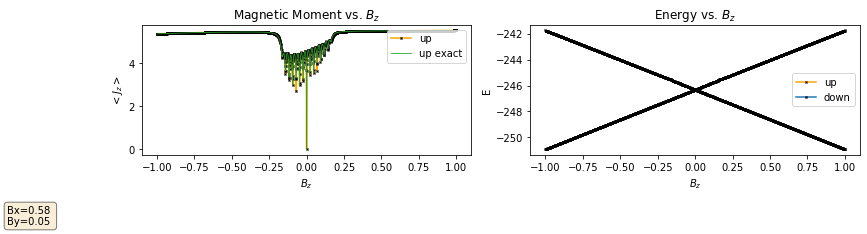

In [15]:
# find the indices of the Bx and By values closest to 1.0 and 0.0
BxIndex=(np.abs(np.array(Bx) - 0.6)).argmin()
ByIndex=(np.abs(np.array(By) - 0.0)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2.,-3.5,'Bx=%0.2f \nBy=%0.2f'%(Bx[BxIndex],By[ByIndex]), bbox=props)
plt.plot(Bz,magnetic_moment_up_arr[:,ByIndex,BxIndex],label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-1.,1.,num=801)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr = np.zeros((2,len(exact_x_arr)))
(_, _, exact_res_arr[0]), (_, _, exact_res_arr[1])=create_slice_exact_diag(Bx[BxIndex],By[ByIndex],exact_x_arr)

# arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

# min_Bz_idx=np.argpartition(np.abs(Bz),2)
# min_Bz_pos=Bz[min_Bz_idx[0]]
# min_Bz_neg=Bz[min_Bz_idx[1]]
# if min_Bz_pos < min_Bz_neg:
#     temp=min_Bz_pos
#     min_Bz_pos=min_Bz_neg
#     min_Bz_neg=temp

# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.2,4),xy=(min_Bz_pos,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props)
# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.2,4),xy=(min_Bz_neg,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props, horizontalalignment='right')

plt.title(r'Magnetic Moment vs. $B_z$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_z$')

# plt.xlim(-1,1)
# plt.ylim(4,6)
# plt.subplot(1,2,2)
# plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
# plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
# plt.title(r'Energy vs. $B_z$')
# plt.legend()
# plt.ylabel('E')
# plt.xlabel(r'$B_z$')

plt.tight_layout()
plt.savefig('energy_and_magnetic_moment_vs_Bz.png',format='png',dpi=500)

plt.show()

# Interpolation

In [90]:
from scipy.interpolate import interpn

In [131]:
# Magnetic moment
points = (Bz, By, Bx)
values = magnetic_moment_up_arr[1:-1,1:-1,1:-1]
point = np.array([0,0.2,0.005])
print(interpn(points, values, point))

# find the indices of the Bx and By values closest to 1.0 and 0.0
Bx_val=0.0
By_val=0.0
BxIndex=(np.abs(np.array(Bx) - Bx_val)).argmin()
ByIndex=(np.abs(np.array(By) - By_val)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-1.,+3.5,'Bx=%0.2f \nBy=%0.2f'%(Bx_val,By_val), bbox=props)
plt.plot(Bz,interpn(points, values,np.array((Bz,By_val*np.ones(len(Bz)),Bx_val*np.ones(len(Bz)))).transpose()),
         label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-1.,1.,num=1601)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr = np.zeros((2,len(exact_x_arr)))
(_, no_hf, exact_res_arr[0]), (_, _, exact_res_arr[1]),_=create_slice_exact_diag(Bx_val,By_val,exact_x_arr)

# arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,no_hf, 'k--', label='no hf', linewidth=1.0, color='black')
# plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

# min_Bz_idx=np.argpartition(np.abs(Bz),2)
# min_Bz_pos=Bz[min_Bz_idx[0]]
# min_Bz_neg=Bz[min_Bz_idx[1]]
# if min_Bz_pos < min_Bz_neg:
#     temp=min_Bz_pos
#     min_Bz_pos=min_Bz_neg
#     min_Bz_neg=temp

# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.2,4),xy=(min_Bz_pos,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props)
# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.2,4),xy=(min_Bz_neg,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props, horizontalalignment='right')

sigma = np.array(( 0.01/(Bz[2]-Bz[1]), 0.01/(By[2]-By[1]), 0.01/(Bx[2]-Bx[1]) ))
y_g1d = ndimage.gaussian_filter(magnetic_moment_up_arr[1:-1,1:-1,1:-1], sigma)
# plt.plot(Bz,y_g1d[:,ByIndex,BxIndex], 'c-.',linewidth=2, label='up avg hf smooth')
plt.plot(Bz,interpn(points, y_g1d,np.array((Bz,By_val*np.ones(len(Bz)),Bx_val*np.ones(len(Bz)))).transpose())
         , 'c-.',linewidth=2, label='up avg hf smooth')

plt.title(r'Magnetic Moment vs. $B_z$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_z$')

# plt.xlim(-1,1)
# plt.ylim(4,6)
# plt.subplot(1,2,2)
# plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
# plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
# plt.title(r'Energy vs. $B_z$')
# plt.legend()
# plt.ylabel('E')
# plt.xlabel(r'$B_z$')

plt.tight_layout()
# plt.savefig('magnetic_moment_vs_Bz.png',format='png',dpi=500)
plt.xlim(-1.3,1.3)
plt.show()

[0.00035926]


In [79]:
# Energy
points = (Bz, By, Bx)
values = energy_up_arr
point = np.array([0,0.2,0.005])
print(interpn(points, values, point))

# find the indices of the Bx and By values closest to 1.0 and 0.0
Bx_val=0.0
By_val=0.0
BxIndex=(np.abs(np.array(Bx) - Bx_val)).argmin()
ByIndex=(np.abs(np.array(By) - By_val)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-1.,+3.5,'Bx=%0.2f \nBy=%0.2f'%(Bx_val,By_val), bbox=props)
plt.plot(Bz,interpn(points, values,np.array((Bz,By_val*np.ones(len(Bz)),Bx_val*np.ones(len(Bz)))).transpose()),
         label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-1.,1.,num=801)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr = np.zeros((2,len(exact_x_arr)))
(_, _, _), (_, _, _), (_, _, exact_res_arr[0])=create_slice_exact_diag(Bx_val,By_val,exact_x_arr)

# arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

# min_Bz_idx=np.argpartition(np.abs(Bz),2)
# min_Bz_pos=Bz[min_Bz_idx[0]]
# min_Bz_neg=Bz[min_Bz_idx[1]]
# if min_Bz_pos < min_Bz_neg:
#     temp=min_Bz_pos
#     min_Bz_pos=min_Bz_neg
#     min_Bz_neg=temp

# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.2,4),xy=(min_Bz_pos,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props)
# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.2,4),xy=(min_Bz_neg,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props, horizontalalignment='right')

sigma = np.array(( 0.01/(Bz[1]-Bz[0]), 0.01/(By[1]-By[0]), 0.01/(Bx[1]-Bx[0]) ))
y_g1d = ndimage.gaussian_filter(energy_up_arr, sigma)
# plt.plot(Bz,y_g1d[:,ByIndex,BxIndex], 'c-.',linewidth=2, label='up avg hf smooth')
plt.plot(Bz,interpn(points, y_g1d,np.array((Bz,By_val*np.ones(len(Bz)),Bx_val*np.ones(len(Bz)))).transpose())
         , 'c-.',linewidth=2, label='up avg hf smooth')

plt.title(r'Energy vs. $B_z$')
plt.legend(loc=1)
plt.ylabel('E')
plt.xlabel(r'$B_z$')

# plt.xlim(-1,1)
# plt.ylim(4,6)
# plt.subplot(1,2,2)
# plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
# plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
# plt.title(r'Energy vs. $B_z$')
# plt.legend()
# plt.ylabel('E')
# plt.xlabel(r'$B_z$')

plt.tight_layout()
plt.savefig('energy_vs_Bz.png',format='png',dpi=500)

plt.show()

[-246.1482502]


In [96]:
import os
def write_to_file(name, data, Bx, By, Bz):
    abs_file_path = name + '.txt'
    with open(abs_file_path, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# {0}\n'.format(data.shape))
        outfile.write('# Bz: %s\n'%np.array2string(Bz,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        outfile.write('# By: %s\n'%np.array2string(By,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        outfile.write('# Bx: %s\n'%np.array2string(Bx,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in data:

            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places.  
            np.savetxt(outfile, data_slice, fmt='%-7.8f')

            # Writing out a break to indicate different slices...
            outfile.write('# New Bz slice\n')


In [97]:
write_to_file('magnetic_moment_up_arr_0.00_hf', y_g1d, Bx, By, Bz)

## Single ion spectrum with adjustable $B_z$ and $B_x$

In [8]:
from matplotlib.widgets import Slider, Button, RadioButtons
# plt.close(fig)
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
bx=0.0
delta_bz=0.005
delta_bx=0.05
by=0.0
bz=0.05
H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
w,v = LA.eigh(H)

magnetic_moments = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
l, = plt.plot(magnetic_moments, w[:16],'k_')
ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
axbz = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axbx = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sbz = Slider(axbz, 'Bz', -.2, .2, valinit=bz, valstep=delta_bz)
sbx = Slider(axbx, 'Bx', -1.0, 3.0, valinit=bx, valstep=delta_bx)

def update(val):
    bz = sbz.val
    bx = sbx.val
    H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
    H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
    w,v = LA.eigh(H)

    magnetic_moments = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
    l.set_xdata(magnetic_moments)
    l.set_ydata(w[:16])
    fig.canvas.draw_idle()


sbz.on_changed(update)
sbx.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sbz.reset()
    sbx.reset()
button.on_clicked(reset)

ax.set_xlim((-6.,6.))
ax.set_ylim((-248,-244))
ax.grid()
plt.show()

## Single ion spectrum with fixed $B_z$ and $B_x$

In [15]:
bx=0.3
by=0.0
bz=0.05
H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
w,v = LA.eigh(H)

magnetic_moments = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
plt.plot(magnetic_moments, w[:16],'k_')
plt.show()

### Plot magnetic moment vs. $B_z$
For the 8 levels out of 16 of the lowest energy that have positive (or at least highest) $\langle J_z \rangle$.

In [5]:
# function to create a slice of the moment & energy functions where bx, by are constants and Bz is an array
# returns exact results in format: (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
def create_slice_exact_diag(bx, by, Bz):
    res_magnetic_moment_up_hf=[]
    res_magnetic_moment_up_no_hf=[]
    res_magnetic_moment_up_hf_avg=[]
    res_magnetic_moment_down_hf=[]
    res_magnetic_moment_down_no_hf=[]
    res_magnetic_moment_down_hf_avg=[]
    res_energy_up_hf_avg=[]
    res_energy_up_hf=[]
    res_energy_down_hf=[]
    for i, bz in enumerate(Bz):
        H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
        H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
        w,v = LA.eigh(H)
        
        # rotate
        change_of_basis_matrix_inverse=np.transpose(v.T)
        change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
        new_jz=change_of_basis_matrix @ np.kron(jz,I_I) @ change_of_basis_matrix_inverse
        for j in range(16):
            if np.allclose(w[j],w[j:j+2],atol=10**-10):
#                 for i in range(v1.T[:,0].size):
#                 v1.T[i,:]*=np.exp(-1j*np.angle(v1.T[i,0]))
                new_jz[j:j+2,j:j+2]=np.diag(LA.eigvalsh(new_jz[j:j+2,j:j+2]))
#                     print("rotated")

        arr = np.real(np.diagonal(new_jz)[:16])
        # ********* UP *********
        # with hf
        k=8        
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_magnetic_moment_up_hf.append(magnetic_moments)
        # Boltzmann weighted averate
        energies = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_energy_up_hf.append(energies)
        beta=1/1.53
        energy_up = np.average(energies,weights=np.exp(-beta*energies))
        avg_magnetic_moment = np.average(magnetic_moments,weights=np.exp(-beta*energies))
        res_magnetic_moment_up_hf_avg.append(avg_magnetic_moment)
        res_energy_up_hf_avg.append(energy_up)
        # w/o hyperfine
        w_no_hf,v_no_hf = LA.eigh(H_cf - H_zeeman)
        k=1
        arr = np.real(np.diagonal(np.conj(v_no_hf.T)@jz@v_no_hf))[:2]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_magnetic_moment_up_no_hf.append(magnetic_moments)
        
        # ******** DOWN ********
        k=8
#         arr = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
        arr = np.real(np.diagonal(new_jz)[:16])
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_magnetic_moment_down_hf.append(magnetic_moments)
        # Boltzmann weighted average
        energies = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_energy_down_hf.append(energies)
        beta=1/1.53
        avg_magnetic_moment = np.average(magnetic_moments,weights=np.exp(-beta*energies))
        res_magnetic_moment_down_hf_avg.append(avg_magnetic_moment)
        # w/o hyperfine
        k=1
        arr = np.real(np.diagonal(np.conj(v_no_hf.T)@jz@v_no_hf))[:2]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_magnetic_moment_down_no_hf.append(magnetic_moments)
    magnetic_moment_up_hf_arr = np.array(res_magnetic_moment_up_hf)
    magnetic_moment_up_no_hf_arr = np.array(res_magnetic_moment_up_no_hf)
    magnetic_moment_up_hf_avg_arr = np.array(res_magnetic_moment_up_hf_avg)
    magnetic_moment_down_hf_arr = np.array(res_magnetic_moment_down_hf)
    magnetic_moment_down_no_hf_arr = np.array(res_magnetic_moment_down_no_hf)
    magnetic_moment_down_hf_avg_arr = np.array(res_magnetic_moment_down_hf_avg)
    res_energy_up_hf_avg_arr = np.array(res_energy_up_hf_avg)
    res_energy_up_hf_arr = np.array(res_energy_up_hf)
    res_energy_down_hf_arr = np.array(res_energy_down_hf)
    return ((magnetic_moment_up_hf_arr, magnetic_moment_up_no_hf_arr, magnetic_moment_up_hf_avg_arr),
           (magnetic_moment_down_hf_arr, magnetic_moment_down_no_hf_arr, magnetic_moment_down_hf_avg_arr),
            (res_energy_up_hf_arr, res_energy_down_hf_arr, res_energy_up_hf_avg_arr))

In [6]:
%matplotlib qt

In [7]:
# plt.close()
# plt.figure(figsize=(12,4))
fig=plt.figure()
bx=2.0
by=0.0
exact_x_arr=np.linspace(-1.0,1.0,num=801)
[exact_res_hf_up_arr, exact_res_no_hf_up_arr, exact_res_hf_avg_up_arr], [exact_res_hf_down_arr, exact_res_no_hf_down_arr, exact_res_hf_avg_down_arr],_ = create_slice_exact_diag(bx,by,exact_x_arr)
lineObjects_up = plt.plot(exact_x_arr,exact_res_hf_up_arr)
# lineObjects_down = plt.plot(exact_x_arr,exact_res_hf_down_arr)
noHFline_up = plt.plot(exact_x_arr,exact_res_no_hf_up_arr,'k--',linewidth=2, label='up no hf')
# noHFline_down = plt.plot(exact_x_arr,exact_res_no_hf_down_arr,'k--',linewidth=2, label='down no hf')
avgHFline_up = plt.plot(exact_x_arr,exact_res_hf_avg_up_arr,'m:',linewidth=2, label='up avg hf')
# N=100
# avg_HFline_smooth_up = plt.plot(exact_x_arr[:len(exact_x_arr)-N+1], pd.Series(exact_res_hf_avg_up_arr).rolling(window=N,win_type='gaussian').mean(std=0.05).iloc[N-1:].values,'c-.',linewidth=2, label='up avg hf smooth')
sigma = 0.01/(exact_x_arr[1]-exact_x_arr[0])
y_g1d = ndimage.gaussian_filter1d(exact_res_hf_avg_up_arr, sigma)
avg_HFline_smooth_up = plt.plot(exact_x_arr,y_g1d, 'c-.',linewidth=2, label='up avg hf smooth')
# avgHFline_down = plt.plot(exact_x_arr,exact_res_hf_avg_down_arr,'m:',linewidth=2, label='down avg hf')
plt.legend(lineObjects_up+noHFline_up+avgHFline_up+avg_HFline_smooth_up, ('-7/2', '-5/2', '-3/2', '-1/2', '1/2', '3/2', '5/2', '7/2', 'no hf','Boltzmann\naverage','Smooth\nBoltzmann\naverage'))
plt.xlabel(r'$B_z$',fontsize=14)
plt.ylabel(r'$\langle J_z \rangle$',fontsize=14)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(.25,1,'Bx=%0.2f \nBy=%0.2f'%(bx,by), bbox=props)
plt.grid()
# fig.savefig(r'figures\magnetic_moment_vs_Bz_hf.pdf')
plt.show()

In [81]:
# plt.close()
# plt.figure(figsize=(12,4))
fig=plt.figure()
bx=0.0
by=0.0
exact_x_arr=np.linspace(-1.0,1.0,num=801)
[exact_res_hf_up_arr, exact_res_no_hf_up_arr, exact_res_hf_avg_up_arr], [exact_res_hf_down_arr, exact_res_no_hf_down_arr, exact_res_hf_avg_down_arr],[exact_energy_res_hf_up_arr, exact_energy_res_hf_down_arr, _] = create_slice_exact_diag(bx,by,exact_x_arr)
lineObjects_up = plt.plot(exact_x_arr,exact_energy_res_hf_up_arr, color='b')
lineObjects_down = plt.plot(exact_x_arr,exact_energy_res_hf_down_arr, color='r')
# lineObjects_down = plt.plot(exact_x_arr,exact_res_hf_down_arr)
# noHFline_up = plt.plot(exact_x_arr,exact_res_no_hf_up_arr,'k--',linewidth=2, label='up no hf')
# noHFline_down = plt.plot(exact_x_arr,exact_res_no_hf_down_arr,'k--',linewidth=2, label='down no hf')
# avgHFline_up = plt.plot(exact_x_arr,exact_res_hf_avg_up_arr,'m:',linewidth=2, label='up avg hf')
# N=100
# avg_HFline_smooth_up = plt.plot(exact_x_arr[:len(exact_x_arr)-N+1], pd.Series(exact_res_hf_avg_up_arr).rolling(window=N,win_type='gaussian').mean(std=0.05).iloc[N-1:].values,'c-.',linewidth=2, label='up avg hf smooth')
# sigma = 0.01/(exact_x_arr[1]-exact_x_arr[0])
# y_g1d = ndimage.gaussian_filter1d(exact_res_hf_avg_up_arr, sigma)
# avg_HFline_smooth_up = plt.plot(exact_x_arr,y_g1d, 'c-.',linewidth=2, label='up avg hf smooth')
# avgHFline_down = plt.plot(exact_x_arr,exact_res_hf_avg_down_arr,'m:',linewidth=2, label='down avg hf')
# plt.legend(lineObjects_up+noHFline_up+avgHFline_up+avg_HFline_smooth_up, ('-7/2', '-5/2', '-3/2', '-1/2', '1/2', '3/2', '5/2', '7/2', 'no hf','Boltzmann\naverage','Smooth\nBoltzmann\naverage'))
plt.xlabel(r'$B_z$',fontsize=14)
plt.ylabel('E',fontsize=14)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(.25,1,'Bx=%0.2f \nBy=%0.2f'%(bx,by), bbox=props)
# plt.grid()
# fig.savefig(r'figures\magnetic_moment_vs_Bz_hf.pdf')
plt.show()

In [6]:
# function to create a slice of the moment & energy functions where bx, by are constants and Bz is an array
# returns exact results in format: (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
def create_slice_exact_Bx_diag(Bx, by, bz):
    res_magnetic_moment_up_hf=[]
    res_magnetic_moment_up_no_hf=[]
    res_magnetic_moment_up_hf_avg=[]
    res_magnetic_moment_down_hf=[]
    res_magnetic_moment_down_no_hf=[]
    res_magnetic_moment_down_hf_avg=[]
    res_energy_up_hf_avg=[]
    res_energy_up_hf=[]
    res_energy_down_hf=[]
    for i, bx in enumerate(Bx):
        H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
        H = np.kron(H_cf - H_zeeman,I_I) + A * (np.kron(jx,ix) + np.kron(jy,iy) + np.kron(jz,iz))# full hamiltonian
        w,v = LA.eigh(H)
        
        # ********* UP *********
        # with hf
        k=8
        arr = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_magnetic_moment_up_hf.append(magnetic_moments)
        # Boltzmann weighted averate
        energies = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_energy_up_hf.append(energies)
        beta=1/1.53
        energy_up = np.average(energies,weights=np.exp(-beta*energies))
        avg_magnetic_moment = np.average(magnetic_moments,weights=np.exp(-beta*energies))
        res_magnetic_moment_up_hf_avg.append(avg_magnetic_moment)
        res_energy_up_hf_avg.append(energy_up)
        # w/o hyperfine
        w_no_hf,v_no_hf = LA.eigh(H_cf - H_zeeman)
        k=1
        arr = np.real(np.diagonal(np.conj(v_no_hf.T)@jz@v_no_hf))[:2]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[-k:])]
        res_magnetic_moment_up_no_hf.append(magnetic_moments)
        
        # ******** DOWN ********
        k=8
        arr = np.real(np.diagonal(np.conj(v.T)@np.kron(jz,I_I)@v))[:16]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_magnetic_moment_down_hf.append(magnetic_moments)
        # Boltzmann weighted average
        energies = w[:16][np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_energy_down_hf.append(energies)
        beta=1/1.53
        avg_magnetic_moment = np.average(magnetic_moments,weights=np.exp(-beta*energies))
        res_magnetic_moment_down_hf_avg.append(avg_magnetic_moment)
        # w/o hyperfine
        k=1
        arr = np.real(np.diagonal(np.conj(v_no_hf.T)@jz@v_no_hf))[:2]
        magnetic_moments = arr[np.sort(np.argpartition(arr, len(arr)-k)[:k])]
        res_magnetic_moment_down_no_hf.append(magnetic_moments)
    magnetic_moment_up_hf_arr = np.array(res_magnetic_moment_up_hf)
    magnetic_moment_up_no_hf_arr = np.array(res_magnetic_moment_up_no_hf)
    magnetic_moment_up_hf_avg_arr = np.array(res_magnetic_moment_up_hf_avg)
    magnetic_moment_down_hf_arr = np.array(res_magnetic_moment_down_hf)
    magnetic_moment_down_no_hf_arr = np.array(res_magnetic_moment_down_no_hf)
    magnetic_moment_down_hf_avg_arr = np.array(res_magnetic_moment_down_hf_avg)
    res_energy_up_hf_avg_arr = np.array(res_energy_up_hf_avg)
    res_energy_up_hf_arr = np.array(res_energy_up_hf)
    res_energy_down_hf_arr = np.array(res_energy_down_hf)
    return ((magnetic_moment_up_hf_arr, magnetic_moment_up_no_hf_arr, magnetic_moment_up_hf_avg_arr),
           (magnetic_moment_down_hf_arr, magnetic_moment_down_no_hf_arr, magnetic_moment_down_hf_avg_arr),
            (res_energy_up_hf_arr, res_energy_down_hf_arr, res_energy_up_hf_avg_arr))

In [43]:
# Magnetic moment

# find the indices of the Bx and By values closest to 1.0 and 0.0
Bz_val=0.15
By_val=0.22
# BxIndex=(np.abs(np.array(Bx) - Bx_val)).argmin()
# ByIndex=(np.abs(np.array(By) - By_val)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.,+3.5,'Bz=%0.2f \nBy=%0.2f'%(Bz_val,By_val), bbox=props)
plt.plot(Bx,interpn(points, values,np.array((Bz_val*np.ones(len(Bx)),By_val*np.ones(len(Bx)),Bx)).transpose()),
         label='up (interp)',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-1.,1.,num=1601)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr = np.zeros((2,len(exact_x_arr)))
(_, no_hf, exact_res_arr[0]), (_, _, exact_res_arr[1]),_=create_slice_exact_Bx_diag(exact_x_arr,By_val,Bz_val)

# arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,no_hf, 'k--', label='no hf', linewidth=1.0, color='black')
# plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

# min_Bz_idx=np.argpartition(np.abs(Bz),2)
# min_Bz_pos=Bz[min_Bz_idx[0]]
# min_Bz_neg=Bz[min_Bz_idx[1]]
# if min_Bz_pos < min_Bz_neg:
#     temp=min_Bz_pos
#     min_Bz_pos=min_Bz_neg
#     min_Bz_neg=temp

# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.2,4),xy=(min_Bz_pos,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props)
# plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.2,4),xy=(min_Bz_neg,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
#             arrowprops=arrow_props, horizontalalignment='right')

sigma = np.array(( 0.01/(Bz[2]-Bz[1]), 0.01/(By[2]-By[1]), 0.01/(Bx[2]-Bx[1]) ))
y_g1d = ndimage.gaussian_filter(magnetic_moment_up_arr, sigma)
# plt.plot(Bz,y_g1d[:,ByIndex,BxIndex], 'c-.',linewidth=2, label='up avg hf smooth')
plt.plot(Bx,interpn(points, y_g1d,np.array((Bz_val*np.ones(len(Bx)),By_val*np.ones(len(Bx)),Bx)).transpose())
         , 'c-.',linewidth=2, label='up avg hf smooth (interp)')

plt.title(r'Magnetic Moment vs. $B_x$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_x$')

# plt.xlim(-1,1)
# plt.ylim(4,6)
# plt.subplot(1,2,2)
# plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
# plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
# plt.title(r'Energy vs. $B_z$')
# plt.legend()
# plt.ylabel('E')
# plt.xlabel(r'$B_z$')

plt.tight_layout()
# plt.savefig('magnetic_moment_vs_Bz.png',format='png',dpi=500)
# plt.xlim(-.3,.3)
plt.show()

In [12]:
%matplotlib qt

# scheme to fit a entire Bx,By,Bz data

In [1]:
loaded3=np.load('Czz3.npz')
magnetic_moment_up_arr=np.real(loaded3['arr_3'])
Bx=loaded3['arr_0']
By=loaded3['arr_1']
Bz=loaded3['arr_2']

NameError: name 'np' is not defined

In [154]:
np.real(magnetic_moment_up_arr[0,0,0])

5.287578310892348

In [156]:
def func(R, a0, a1, a2, b0, b1, b2, c0, c1, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5, a6, b6, c6):
    #p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19

    x = R[0:81]
    y = R[81:81+81]
    z = R[81+81:]
    x,y,z = np.meshgrid(x,y,z)
    
    g = ((a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5 + a6*x**6)*
         (b0 + b1*y + b2*y**2 + b3*y**3 + b4*y**4 + b5*y**5 + b6*y**6)*
         (c0 + c1*z + c2*z**2 + c3*z**3 + c4*z**4 + c5*z**5 + c6*z**6))
    
    #g = (p0 + p1*x + p2*y + p3*z + p4*x*y + p5*x*z + p6*y*z + p7*x**2 + p8*y**2 +
    #     p9*z**2 + p10*x**3 + p11*y**3 + p12*z**3 + p13*x**2*y + p14*x**2*z + p15*y**2*x + p16*y**2*z
    #     + p17*z**2*x + p18*z**2*y + p19*x*y*z)
    return g.ravel()


In [108]:
def func(R, a0, a1, a2, b0, b1, b2, c0, c1, c2, a3, b3, c3):
    x = R[0:22]
    y = R[22:44]
    z = R[44:]
    x,y,z = np.meshgrid(x,y,z)
    g = ((a0 + a1*x + a2*x**2 + a3*x**3)*
         (b0 + b1*y + b2*y**2 + b3*y**3)*
         (c0 + c1*z + c2*z**2 + c3*z**3))
    
    #g = (p0 + p1*x + p2*y + p3*z + p4*x*y + p5*x*z + p6*y*z + p7*x**2 + p8*y**2 +
    #     p9*z**2 + p10*x**3 + p11*y**3 + p12*z**3 + p13*x**2*y + p14*x**2*z + p15*y**2*x + p16*y**2*z
    #     + p17*z**2*x + p18*z**2*y + p19*x*y*z)
    return g.ravel()

In [157]:
x_data=np.concatenate((Bx, By, Bz))
y_data=magnetic_moment_up_arr.T.ravel()
p0=[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ]
params, params_covariance = optimize.curve_fit(func, x_data, y_data, p0=p0)

print(params)
# calculate R^2
residuals = y_data.ravel() - func(x_data, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print('R^2 (%s)=%s'%(func.__name__,str(r_squared)))

#plt.plot(x_data, func(x_data, *params), label=func.__name__)

[-4.49551818e+01 -5.26210083e-05  1.27013391e-01  3.23533969e+03
  3.24372143e-03 -9.12117861e+00 -3.76988203e-05  2.06522235e-12
 -2.46051793e-10  9.23236880e-06 -5.78114348e-04 -1.93982604e-13
 -8.09466730e-03  5.80188549e-01  1.41860592e-10 -3.10010763e-07
  1.96248146e-05 -1.72344759e-13  1.64014829e-04 -1.17369373e-02
 -2.11113148e-11]
R^2 (func)=0.09189172483312236


In [179]:
from matplotlib.lines import Line2D

index=30
plt.figure(figsize=(10,10))
#data
h1 = plt.contour(Bx,By,magnetic_moment_up_arr[index].T,colors='r')
#fit
h2 = plt.contour(Bx,By,func(x_data,*params).reshape(len(Bx),len(By),len(Bz))[:,:,index],colors='b')

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

plt.gca().legend(custom_lines, ['data', 'fit'])

plt.clabel(h1, inline=1, fontsize=10)     
plt.clabel(h2, inline=1, fontsize=10)
plt.text(1.05,.95,'Bz=%1.4f'%Bz[index])
plt.xlabel('Bx')
plt.ylabel('By')
# plt.gcf().savefig('fit.png')
plt.show()


In [44]:
loaded3=np.load('Czz3.npz')
magnetic_moment_up_arr=np.abs(np.real(loaded3['arr_3']))[0]
Bx=loaded3['arr_0']
By=loaded3['arr_1']
Bz=loaded3['arr_2']
Bx=Bx[(Bx>-2.) & (Bx<2.)]
By=By[(By>-2.) & (By<2.)]

In [6]:
magnetic_moment_up_arr[40,40]

5.511060633647517

In [11]:
def test_func(*p):
    print(p)
    print(len(p))
    print(p[:int(len(p)/2)])
    print(p[int(len(p)/2):])

In [13]:
test_func(1,2,3,4,5,6,7)

(1, 2, 3, 4, 5, 6, 7)
7
(1, 2, 3)
(4, 5, 6, 7)


In [38]:
def func(R, *p):
    if len(p)%2!=0:
        raise Exception("Number of arguments must be even.")

    x = R[0:81]
    y = R[81:]
    x,y = np.meshgrid(x,y)
    
    g = np.polyval(p[:int(len(p)/2)], x) * np.polyval(p[int(len(p)/2):], y)
    
    #g = (p0 + p1*x + p2*y + p3*z + p4*x*y + p5*x*z + p6*y*z + p7*x**2 + p8*y**2 +
    #     p9*z**2 + p10*x**3 + p11*y**3 + p12*z**3 + p13*x**2*y + p14*x**2*z + p15*y**2*x + p16*y**2*z
    #     + p17*z**2*x + p18*z**2*y + p19*x*y*z)
    return g.ravel()


In [34]:
def func_polar(R, *p):
    if len(p)%2!=0:
        raise Exception("Number of arguments must be even.")

    x = R[0:81]
    y = R[81:]
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(x, y)
    r,theta = np.meshgrid(r,theta)
    
    g = np.polyval(p[:int(len(p)/2)], r) * np.polyval(p[:int(len(p)/2)], theta)
    
    #g = (p0 + p1*x + p2*y + p3*z + p4*x*y + p5*x*z + p6*y*z + p7*x**2 + p8*y**2 +
    #     p9*z**2 + p10*x**3 + p11*y**3 + p12*z**3 + p13*x**2*y + p14*x**2*z + p15*y**2*x + p16*y**2*z
    #     + p17*z**2*x + p18*z**2*y + p19*x*y*z)
    return g.ravel()


In [39]:
x_data=np.concatenate((Bx, By))
y_data=magnetic_moment_up_arr.T.ravel()
p0=[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1 ]
params, params_covariance = optimize.curve_fit(func, x_data, y_data, p0=p0)

print(params)
# calculate R^2
residuals = y_data.ravel() - func(x_data, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print('R^2 (%s)=%s'%(func.__name__,str(r_squared)))

#plt.plot(x_data, func(x_data, *params), label=func.__name__)

[-1.92505547e-09 -6.80844594e-08  2.37580120e-08  5.37203268e-06
  7.86589837e-06 -9.91795122e-05 -4.15223336e-04 -2.88669355e-03
  8.94751233e-03  1.53938885e-01 -9.61652186e-02 -2.74382107e+00
  5.10394657e-01  2.49825234e+01 -1.15339185e+00 -1.30135734e+02
  7.09743944e-01  2.35822074e+04 -4.75657817e-19  6.17407121e-15
  4.93914143e-17 -6.55344349e-13 -2.11700053e-15  2.88350906e-11
  4.85188589e-14 -6.82597800e-10 -6.43855716e-13  9.47223207e-09
  4.99920311e-12 -7.95048411e-08 -2.17417281e-11  4.15149309e-07
  4.67384129e-11 -1.48703177e-06 -3.55008545e-11  2.33280482e-04]
R^2 (func)=0.9600764064923176


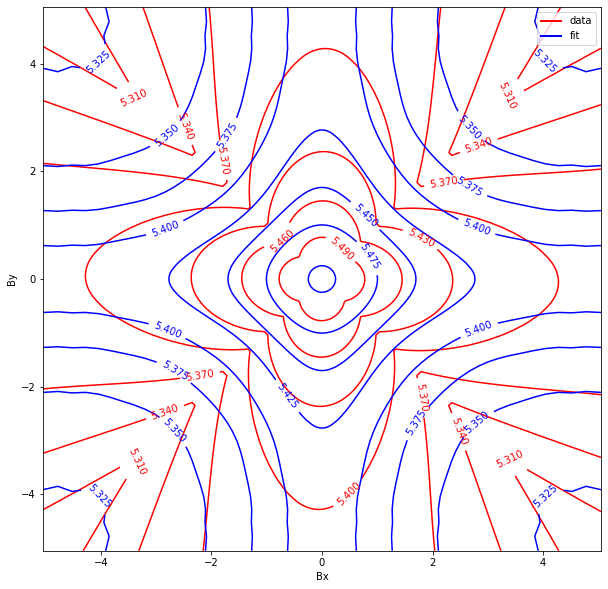

In [37]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10,10))
#data
h1 = plt.contour(Bx,By,magnetic_moment_up_arr.T,colors='r')
#fit
h2 = plt.contour(Bx,By,func(x_data,*params).reshape(len(Bx),len(By)),colors='b')

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

plt.gca().legend(custom_lines, ['data', 'fit'])

plt.clabel(h1, inline=1, fontsize=10)     
plt.clabel(h2, inline=1, fontsize=10)
# plt.text(1.05,.95,'Bz=%1.4f'%Bz[index])
plt.xlabel('Bx')
plt.ylabel('By')
# plt.gcf().savefig('fit.png')
plt.show()


# scheme to fit a single Bz layer

In [10]:
Bz.size

1603

In [89]:
def func_quad(xyz, p0, p1, p2, p3, p4, p5):
    #p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19
    x, y = R
    x, y = np.meshgrid(x, y)  
    g = (p0 + p1*x + p2*y + p3*x*y + p4*x**2 + p5*y**2)
    return g.ravel()


In [100]:
np.concatenate([Bx, Bz])

array([-1.        , -0.89473684, -0.78947368, ...,  0.9975    ,
        0.99875   ,  1.        ])

In [94]:
x_data=np.array([Bx, Bz],dtype=float)
y_data=magnetic_moment_up_arr[Bz_index]

p0=[ 5.51, 1, 1, 1, 1, 1 ]
print(func_quad(x_data,*p0).shape)
params, params_covariance = optimize.curve_fit(func_quad, x_data, y_data.ravel(), p0=p0)

print(params)
# calculate R^2
residuals = y_data.ravel() - func_quad(x_data, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print('R^2 (%s)=%s'%(func.__name__,str(r_squared)))

ValueError: setting an array element with a sequence.

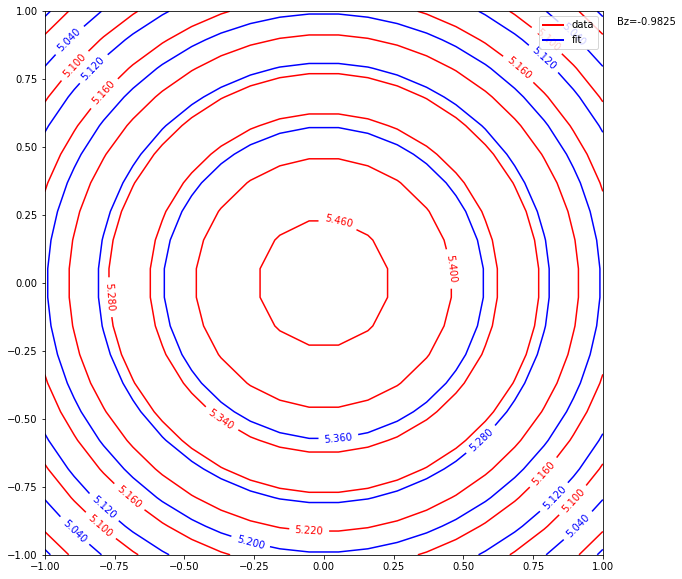

In [93]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10,10))
#data
h1 = plt.contour(Bx,By,y_data,colors='r')
#fit
h2 = plt.contour(Bx,By,func_quad((Bx,By),*params).reshape(20,20),colors='b')

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

plt.gca().legend(custom_lines, ['data', 'fit'])

plt.clabel(h1, inline=1, fontsize=10)     
plt.clabel(h2, inline=1, fontsize=10)
plt.text(1.05,.95,'Bz=%1.4f'%Bz[Bz_index])
plt.show()

In [38]:
mat=np.array([[0.1,10],
              [10,-0.1]])
_, vec = np.linalg.eig(mat)
print(np.transpose(vec[0])@np.array([[1,0],[0,-1]])@vec[0])
print(np.transpose(vec[1])@np.array([[1,0],[0,-1]])@vec[1])
vec

0.009999500037496833
-0.009999500037496833


array([[ 0.71063334, -0.70356254],
       [ 0.70356254,  0.71063334]])